<h1>Word2Vecf on Chess Puzzle Data</h1>

In [1]:
#Word 2 Vec F test
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
tqdm().pandas()

TRAIN_DAT = '/w/225/1/chess/tactics/parameter_tuning_files/train_full_set'
CONTEXT_DAT = '/w/225/1/chess/tactics/parameter_tuning_files/cv_full_set'
VOCAB_DAT = '/w/225/1/chess/tactics/parameter_tuning_files/wv_full_set'
PPMI_TAB = '/w/225/1/chess/tactics/parameter_tuning_files/sample_pairs_ppmi'

#TRAIN_DAT = '/w/225/1/chess/tactics/parameter_tuning_files/train_full_set_failed'
#CONTEXT_DAT = '/w/225/1/chess/tactics/parameter_tuning_files/cv_full_set_failed'
#VOCAB_DAT = '/w/225/1/chess/tactics/parameter_tuning_files/wv_full_set_failed'
#PPMI_TAB = '/w/225/1/chess/tactics/parameter_tuning_files/sample_pairs_ppmi_failed'

/h/224/stevenhl/miniconda3/envs/chess/lib/python3.8/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [61]:
with open(CONTEXT_DAT) as myfile:
    head = [next(myfile) for x in range(10)]
print(head)

['00000898c4d3f4644a95cbe3e167ac37762a016a99ca1f0280a7920c3fb4e16c 1\n', '000016ae6693789632f6cafd4515ff7d9fec623cd04cda82089320b8be5b376b 1\n', '00001c95453dafe56fc3cdf7f17a78c118aa8060fdf72df96072bc761604bba6 6\n', '00002d5d9e845a51a055bd3359353b9c59a2b775c5d43d6f70b99d064ba7a4c1 9\n', '000032f45b621e47a6d2964692b95e044adbd7d37950fdeb6404e5db4f6aaf81 2\n', '0000548188f5c98b797e93037a520d34afdf78efbb057da537792209ed5d3202 4\n', '000068d3aa3a7d4bb9d0b67ed0f5ad3b14c4552b20ba37d88b00186e4672cb5c 4\n', '00006cdfb66062de722f830a4ff288694f1ae1690da912c0508ea2e5ba1f053c 13\n', '00007dd32c35a45c80d95e38bdde706009b3d2bdc2f61009b928481bf5558014 14\n', '0000a658603f7ff787047043ae889de36319a58ea24712cd396dda0586a137db 1\n']


<h2>Load, Filter, Save Data for Loading to Word2vecf</h2>

In [2]:
#Load Data
chess_data = pd.read_csv('/w/225/1/chess/tactics/glicko_user_tactics_problem.csv_00')

In [3]:
#Filter Data
chess_data = chess_data[chess_data.is_passed == 1]

In [4]:
len(chess_data)

73450218

In [5]:
#Create vocabulary file for word2vecf
vocab_dat = chess_data.groupby('tactics_problem_id')['user_hash'].nunique().to_frame()
#Number of vocab words in 'corpus'
len(vocab_dat.index)

42278

In [6]:
#Get the count of puzzles attempted per each user, ie create the context file for word2vecf
context_dat = chess_data.groupby('user_hash')['tactics_problem_id'].nunique().to_frame()
context_dat.head()

,tactics_problem_id
user_hash,
00001c95453dafe56fc3cdf7f17a78c118aa8060fdf72df96072bc761604bba6,1
00002d5d9e845a51a055bd3359353b9c59a2b775c5d43d6f70b99d064ba7a4c1,2
0000548188f5c98b797e93037a520d34afdf78efbb057da537792209ed5d3202,2
00006cdfb66062de722f830a4ff288694f1ae1690da912c0508ea2e5ba1f053c,4
00007dd32c35a45c80d95e38bdde706009b3d2bdc2f61009b928481bf5558014,3


In [7]:
#Write to CSV the training, vocab and context data
#Convert indexes to columns
vocab_dat.reset_index(level=0, inplace=True)
vocab_dat.to_csv('/w/225/1/chess/tactics/parameter_tuning_files/wv_full_set',
                 sep=' ',
                 index=False,
                 header=False,
                 encoding='utf-8')

In [8]:
context_dat.reset_index(level=0,inplace=True)
context_dat.to_csv('/w/225/1/chess/tactics/parameter_tuning_files/cv_full_set',
                 sep=' ',
                 index=False,
                 header=False,
                 encoding='utf-8')

In [9]:
#Filter and reorder columns
#chess_data = chess_data.filter(items=['user_hash','tactics_problem_id'])
chess_data = chess_data[['tactics_problem_id','user_hash']]
chess_data.head()
chess_data.to_csv('/w/225/1/chess/tactics/parameter_tuning_files/train_full_set',
                 sep=' ',
                 index=False,
                 header=False,
                 encoding='utf-8')

<h2>Create Pairs of random vocab words to generate PPMIs</h2>

In [96]:
#Create a bunch of random pairs of 
pairs_to_sample = 1000000 # will be less b.c. duplicates
vocab_dat = vocab_dat.set_index('tactics_problem_id')
pairs = np.random.choice(vocab_dat.index, (pairs_to_sample,2))
pairs = pairs[pairs[:, 0] != pairs[:, 1]]
print(pairs[:5])
print(pairs.shape)

[[ 49380 107095]
 [ 29069  29424]
 [159734  99303]
 [ 90318  33369]
 [ 46199  54604]]
(999975, 2)


In [101]:
#Join pairs with their user counts for each puzzle
pmi_table = pd.DataFrame(data=pairs,columns=["puz_a","puz_b"])
pmi_table = pd.merge(pmi_table,vocab_dat,how='left',left_on='puz_a',right_on='tactics_problem_id')
#mi_table.columns = ['puz_a','puz_b','users_a',]
pmi_table = pd.merge(pmi_table,vocab_dat,how='left',left_on='puz_b',right_on='tactics_problem_id')
pmi_table.columns = ['puz_a','puz_b','users_a','users_b']
pmi_table.head()

,puz_a,puz_b,users_a,users_b
0,49380,107095,3709,91
1,29069,29424,172,3040
2,159734,99303,53,19
3,90318,33369,1841,683
4,46199,54604,4087,1566


In [102]:
#Sort for speeding up finding counts of shared users later
chess_data.sort_values(by="tactics_problem_id",inplace=True)
chess_data.head()

,tactics_problem_id,user_hash
7720,731,fc8de4a6060205284a24b107d1085d520f545964f660a5...
59761584,731,173c92bf4899d9fa284a7243f741a6494dbe854937b987...
18650605,731,cc6ab3f8acaf8a643b1f91dbd30d56855fc8cd4a46e167...
73199415,731,904358b1f756ebdb56b7e1b9cd6399b17fb7c3cc19236d...
35112994,731,34501ed24536c78449532fdeaac4ca1a58efe422cc227a...


In [104]:
#Drop Index
chess_data = chess_data.reset_index()
chess_data = chess_data.drop('index',axis=1)
chess_data.head()

,tactics_problem_id,user_hash
0,731,fc8de4a6060205284a24b107d1085d520f545964f660a5...
1,731,173c92bf4899d9fa284a7243f741a6494dbe854937b987...
2,731,cc6ab3f8acaf8a643b1f91dbd30d56855fc8cd4a46e167...
3,731,904358b1f756ebdb56b7e1b9cd6399b17fb7c3cc19236d...
4,731,34501ed24536c78449532fdeaac4ca1a58efe422cc227a...


In [116]:
#Calculate number of users that have completed both puzzles for each pair
import time
def get_shared_user(row):
    #temp = chess_data[(chess_data['tactics_problem_id'] == row['puz_a']) | (chess_data['tactics_problem_id'] == row['puz_b'])]
    #return(len(temp[temp.duplicated(['user_hash'])]))
    #Option B, slightly slower
    #user_a = chess_data[chess_data['tactics_problem_id'] == row['puz_a']]
    #user_b = chess_data[chess_data['tactics_problem_id'] == row['puz_b']]
    #return(len(pd.merge(user_a,user_b,how='inner',on='user_hash')))
    #Option C, requires sorted list, fastest
    a_start = np.searchsorted(chess_data['tactics_problem_id'],row['puz_a'])
    #print(a_first_index)
    b_start = np.searchsorted(chess_data['tactics_problem_id'],row['puz_b'])
    user_a = chess_data.iloc[a_start:a_start+row['users_a']]
    user_b = chess_data.iloc[b_start:b_start+row['users_b']]
    return(len(pd.merge(user_a,user_b,how='inner',on='user_hash')))

start = time.time()
pmi_table['users_a_b'] = pmi_table.progress_apply(lambda row: get_shared_user(row),axis=1)
end = time.time()
print(end-start)


8201.523441076279


In [134]:
pmi_table.shape

(999989, 5)

In [117]:
#Calculate pointwise mutual information for each pair
def calc_pmi(row,vocab_len):
    if(row['users_a_b'] == 0): return 0
    return np.log(row['users_a_b']) + vocab_len - np.log(row['users_a']) - np.log(row['users_b'])

vocab_len = np.log(len(vocab_dat.index))
pmi_table['pmi'] = pmi_table.apply(lambda row: calc_pmi(row,vocab_len),axis=1)
#Filter out negative values to get Postivive PMI
pmi_table = pmi_table[pmi_table['pmi'] > 0]
pmi_table.head()

,puz_a,puz_b,users_a,users_b,users_a_b,pmi
6,99759,106127,223,596,5,0.463125
9,188218,51179,416,236,7,1.102492
12,54028,98661,2008,2663,177,0.335146
23,49534,468557,329,117,1,0.092868
24,113934,168590,2003,280,15,0.121959


In [118]:
#Save PPMI
pmi_table.to_csv('/w/225/1/chess/tactics/parameter_tuning_files/sample_pairs_ppmi_failed',
                 encoding='utf-8')

<h2>Create embeddings for different hyperparameter combos</h2>

In [2]:
#Set up range of hyperparamters to try for tuning
param1 = "alpha"
#param1_values = np.array([0.02, 0.04, 0.06, 0.08, 0.1])
param1_values = np.array([0.16])
param2 = "size"
#param2_values = np.array([262, 265, 268, 271, 274])
param2_values = np.array([265])

param3 = "negative"
#param3_values = np.array([26, 27, 28, 29, 30])
param3_values = 28

param4 = "sample"
#param4_values = np.array([0.35, 0.4, 0.45, 0.55, 0.6])
param4_values = 0.35

print(param1_values)
print(param2_values)

#print(param3_values)
#print(param4_values)

all_embeddings = [(p1, p2) for p1 in param1_values for p2 in param2_values]
#all_embeddings = [(p3, p4) for p3 in param3_values for p4 in param4_values]

[0.16]
[265]


In [3]:
all_embeddings

[(0.16, 265)]

In [4]:
import subprocess
import sys

def generate_embedding(tpl):
    #p3, p4 = tpl
    p1, p2 = tpl
    output = f"word2vecf/vectors/size_alpha/vecs_{p1}_{p2}.txt"
    #output = f"word2vecf/vectors/negative_sample/vecs_{p3}_{p4}.txt"
    command = f"word2vecf/word2vecf -train {TRAIN_DAT} -wvocab {VOCAB_DAT} -cvocab {CONTEXT_DAT} -output {output} -threads 180 -{param1} {p1} -{param2} {p2} -negative 28 -sample 0.35"
    #command = f"word2vecf/word2vecf -train {TRAIN_DAT} -wvocab {VOCAB_DAT} -cvocab {CONTEXT_DAT} -output {output} -threads 180 -alpha 0.15 -size 250 - {param3} {p3} -{param4} {p4}"
    
    subprocess.run(command, shell=True)
    
    with open(output) as myfile:
        head = [next(myfile) for x in range(5)]
    print(head)
    
    return output
    
generated_embeddings = list(map(generate_embedding, tqdm(all_embeddings)))

['42278 265\n', '731 -0.273811 0.064698 0.012569 0.006050 -0.377835 0.068170 0.553531 0.178029 0.397813 -0.027913 0.201066 0.216607 -0.084713 0.251497 0.193430 -0.202582 -0.101789 -0.137807 0.119573 -0.391823 -0.075476 0.046010 -0.158311 0.378781 -0.152374 -0.014017 -0.351324 -0.036963 0.083119 -0.136642 -0.116698 -0.308162 -0.057720 0.364979 -0.109130 -0.201203 0.194941 -0.110845 0.098594 0.390823 -0.166659 -0.178307 0.178717 0.133402 -0.243822 -0.385994 0.081304 0.345918 -0.223074 -0.378593 0.256744 0.017918 -0.099751 0.235483 0.335474 -0.160083 -0.466410 -0.289641 -0.294015 0.249351 -0.147339 0.080758 -0.115154 -0.145501 -0.017159 -0.204816 0.097164 0.222405 -0.261852 0.312423 -0.033550 0.028939 0.047223 -0.157820 0.160306 0.099855 0.060759 0.047253 -0.357961 -0.011064 -0.049189 -0.110230 -0.004523 -0.354684 0.507643 0.036592 0.091528 -0.428848 0.418916 -0.184762 0.101627 0.452782 -0.175757 -0.278496 0.364562 0.519110 -0.282638 -0.537899 0.052022 -0.325137 0.074971 -0.398539 -0.0289

In [5]:
#Load embeddings

def load_embedding(filename):
    vectors = pd.read_csv(filename, sep=' ', header=None, skiprows=1)
    #Set index to be the first column which contains the puzzle IDs
    vectors = vectors.set_index(0)
    #Get rid of empty column at end
    vectors = vectors.drop(len(vectors.columns),axis=1)
    #vectors = vectors = vectors.iloc[:, 0:200]
    #Normalize puzzle vectors
    vectors = vectors.divide(np.linalg.norm(vectors, axis=1), axis=0)
    return vectors

loaded_embeddings = list(map(lambda x: load_embedding(x), tqdm(generated_embeddings)))

In [7]:
loaded_embeddings

[             1         2         3         4         5         6         7    \
 0                                                                              
 731    -0.074564  0.017618  0.003423  0.001648 -0.102891  0.018564  0.150737   
 746    -0.001494  0.041922 -0.049483 -0.001120 -0.024400 -0.081619  0.076401   
 27811   0.051139  0.086621 -0.050194 -0.040887 -0.052669 -0.049051  0.047905   
 905     0.013901  0.086103 -0.080856 -0.008177 -0.043284 -0.053861  0.060034   
 48779   0.016093  0.084494 -0.045022 -0.038027 -0.069925 -0.050765  0.072574   
 ...          ...       ...       ...       ...       ...       ...       ...   
 386259 -0.043087 -0.022570  0.011684  0.017362  0.015008 -0.011224  0.155107   
 391319 -0.044721 -0.016157  0.007500  0.019504  0.016111 -0.004336  0.152400   
 397091 -0.070533 -0.031068 -0.009931  0.033456  0.027996 -0.009771  0.174996   
 408141 -0.073338  0.003987  0.022723  0.032296  0.029382 -0.017982  0.138977   
 424251 -0.065990 -0.009025 

In [8]:
ppmi = pd.read_csv(PPMI_TAB).drop('Unnamed: 0',axis=1)
ppmi

,puz_a,puz_b,users_a,users_b,users_a_b,pmi
0,159895,63342,3006,2516,351,0.674017
1,120701,84914,3982,2850,386,0.363246
2,52531,27906,3719,3723,505,0.433085
3,115098,155221,376,169,7,1.538444
4,29644,147189,3618,3079,716,0.999665
...,...,...,...,...,...,...
408768,30205,173206,3818,4343,665,0.528007
408769,26900,33234,2702,590,66,0.559807
408770,151395,81844,2958,1750,182,0.396389
408771,30904,121287,616,2302,45,0.293904


In [9]:
#Assess PPMI

#Load PMI


def assess_ppmi(embedding):
    vecs_a = embedding.reindex(ppmi["puz_a"].astype(int))
    vecs_b = embedding.reindex(ppmi["puz_b"].astype(int))
    cosines = np.multiply(vecs_a, vecs_b).sum(1)
    ppmis = ppmi["pmi"]
    
    corr = np.corrcoef(cosines, ppmis)
    return corr[0,1]
    
    
assessment_scores = np.array(list(map(assess_ppmi, tqdm(loaded_embeddings))))

In [11]:
assessment_scores

array([0.6979398])

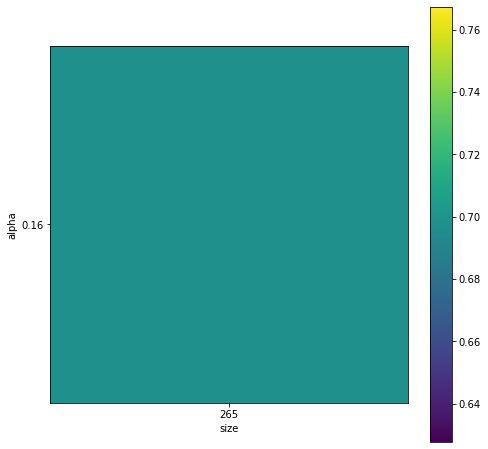

In [19]:
import matplotlib.pyplot as plt
#grid = np.arange(0, len(all_embeddings)).reshape((len(param3_values), len(param4_values)))
grid = np.arange(0, len(all_embeddings)).reshape((len(param1_values), len(param2_values)))

scores = assessment_scores.copy()
plt.figure(figsize=(8,8))
plt.imshow(scores[grid])
#plt.yticks(np.arange(0, len(param3_values)), ["%d" % d for d in param3_values])
plt.yticks(np.arange(0, len(param1_values)), ["%.2f" % d for d in param1_values])
#plt.xticks(np.arange(0, len(param4_values)), ["%.9f" % d for d in param4_values])
plt.xticks(np.arange(0, len(param2_values)), ["%d" % d for d in param2_values])
#plt.ylabel(param3)
plt.ylabel(param1)
#plt.xlabel(param4)
plt.xlabel(param2)
plt.colorbar()
plt.show()

In [27]:
grid

array([[ 0,  1,  2,  3,  4],
       [ 5,  6,  7,  8,  9],
       [10, 11, 12, 13, 14],
       [15, 16, 17, 18, 19],
       [20, 21, 22, 23, 24]])

In [55]:
#plt.savefig('5_5_correlation_matrix_size_alpha.png')
plt.savefig('5_5_correlation_matrix_negative_sample_size_250_alpha_0.15.png')

<Figure size 432x288 with 0 Axes>

In [ ]:
def cosine_similarities(embedding):
    vecs_a = embedding.reindex(ppmi["puz_a"].astype(int))
    vecs_b = embedding.reindex(ppmi["puz_b"].astype(int))
    cosines = np.multiply(vecs_a, vecs_b).sum(1)
    return cosines

cos_sim = np.array(list(map(cosine_similarities, tqdm(loaded_embeddings))))

In [60]:
cos_sim[0]

array([0.77042279, 0.60559717, 0.37939813, ..., 0.67443264, 0.57945318,
       0.82181196])

In [ ]:
small_puz_a = ppmi.iloc[0:50,0]
small_puz_b = ppmi.iloc[0:50,0]

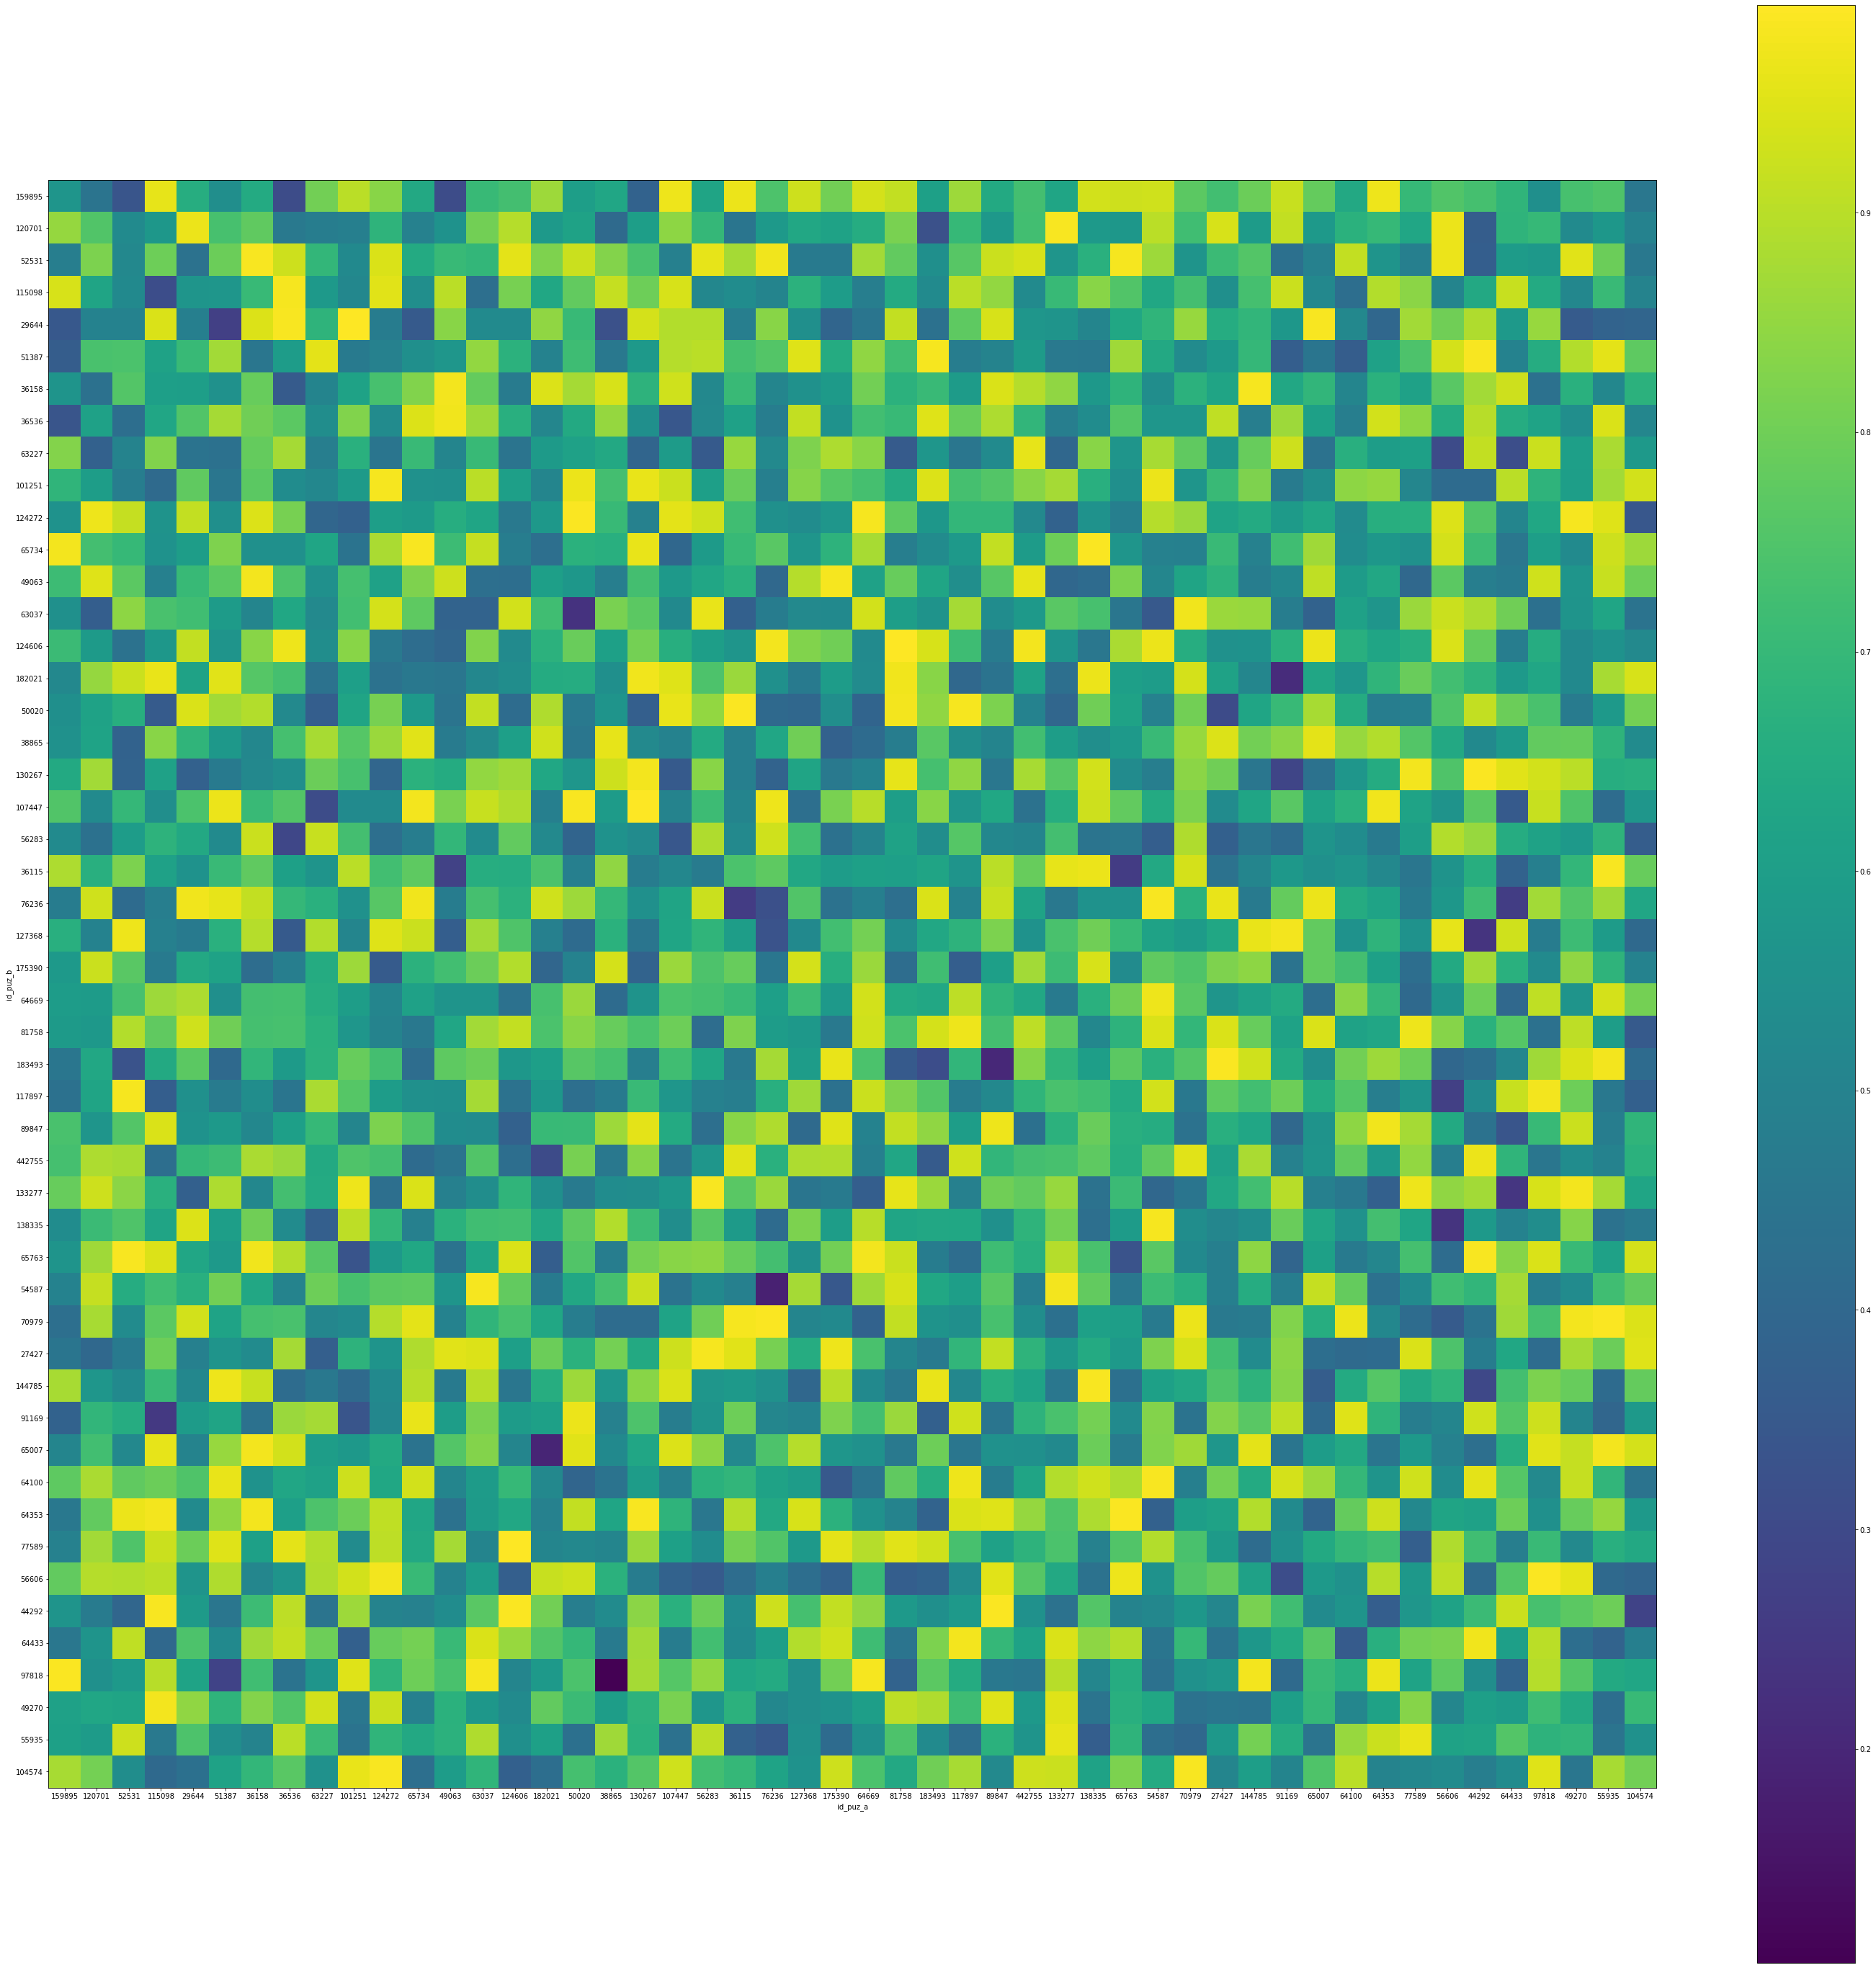

In [26]:
ind = 0
for i in range(2,3):
    for j in range(1,2):
        p3 = param1_values[i]
        p4 = param2_values[j]

        grid = np.arange(0, len(small_puz_a) * len(small_puz_b)).reshape((len(small_puz_a), len(small_puz_b)))

        similarity_scores = cos_sim[ind].copy()
        ind = ind + 1
        plt.figure(figsize=(50,50))
        plt.imshow(similarity_scores[grid])
        plt.yticks(np.arange(0, len(small_puz_b)), ["%d" % d for d in small_puz_b])
        plt.xticks(np.arange(0, len(small_puz_a)), ["%d" % d for d in small_puz_a])
        plt.ylabel("id_puz_b")
        plt.xlabel("id_puz_a")
        plt.colorbar()
        plt.show()

        
#plt.savefig('50_50_cosine_similarity_negative_20_sample_0.1_size_250_alpha_0.15.png')        

<h2>Prepare Data for Projector</h2>

In [12]:
#vectors = pd.read_csv("word2vecf/vectors/dim200puzzlevec", sep=' ', header=None, skiprows=1)
#Remove Empty column at end of file

#vectors = vectors.drop(vectors.shape[1]-1,axis=1)
#Create puzzle_vocabulary data frame from first column of vectors and then remove vector id column from vectors
max_index = np.where(assessment_scores == max(assessment_scores))[0][0]
vectors = loaded_embeddings[max_index]
vectors.reset_index(level=0, inplace=True)
vectors.rename(columns={0:'tactics_problem_id'}, inplace=True)
puzzle_vocabulary_pd = vectors['tactics_problem_id'].to_frame().astype('int32').set_index("tactics_problem_id")
vectors = vectors.drop('tactics_problem_id',axis=1)

In [13]:
vectors.shape

(42278, 265)

<h2>Load Puzzle MetaData</h2>

In [14]:
#Load Fen Data
fen_data = pd.read_csv('/w/225/1/chess/tactics/tactics_problem.csv')

In [15]:
#Extract PGN and FEN
import re
old_pgn = fen_data['pgn']
new_pgn = np.array([])
for i in range(0,len(old_pgn)):
    old_fen = old_pgn[i]
    try:
        string = re.search('\[FEN \"(.+?)\"\]', old_fen).group(1)
        string = string.replace(' ','_')
        #print(string)
    except:
        string = ''
    new_pgn = np.append(new_pgn,'https://lichess.org/analysis/' + string)
print(new_pgn)


['https://lichess.org/analysis/r1b2rk1/ppp2ppp/1b3N2/3q4/3p4/Q4N2/PPP2KPP/R1B1R3_b_-_-_0_12'
 'https://lichess.org/analysis/r6k/1q1n1prp/p3pN1Q/1p1b4/6R1/6P1/PP2PP1P/3R2K1_b_-_-_1_1'
 'https://lichess.org/analysis/3rr1k1/ppp2ppp/8/5Q2/4n3/1B5R/PPP2PP1/5qK1_w_-_-_1_2'
 ...
 'https://lichess.org/analysis/5r2/8/p2pBbkp/3P2p1/3n4/B7/P4PPP/4R1K1_b_-_-_4_34'
 'https://lichess.org/analysis/r1b2r2/pp4k1/1bpp1q1p/5ppQ/2B2NN1/2P5/P5PP/R1B1R2K_b_-_-_2_22'
 'https://lichess.org/analysis/r2q1bk1/p6p/1p2pNp1/2p1Q3/3n2P1/1P6/PBPP3P/5RK1_b_-_-_1_19']


In [16]:
#np.save('fen_links.npy',new_pgn)
#Add FEN Data to 
#new_pgn = np.load('fen_links.npy')
fen_data['pgn'] = new_pgn
fen_data.rename(columns={'pgn':'fen'}, inplace=True)

In [17]:
#puzzle_vocabulary_pd = puzzle_vocabulary_pd.join(tag_data.set_index('tactics_problem_id'))
puzzle_vocabulary_pd = puzzle_vocabulary_pd.join(fen_data.set_index('tactics_problem_id'))

In [18]:
#IMPORTANT remove empty values, causes issues with projector
puzzle_vocabulary_pd = puzzle_vocabulary_pd.replace(np.nan, 0,regex=True)
puzzle_vocabulary_pd.reset_index(level=0, inplace=True)

In [19]:
#Set data types back to int32 for numeric columns
puzzle_vocabulary_pd.astype({'rating': 'int32','attempt_count': 'int32','average_seconds':'int32','move_count':'int32'}).dtypes
#Check for Null values
print(len(puzzle_vocabulary_pd) - puzzle_vocabulary_pd.count())
puzzle_vocabulary_pd.head()

tactics_problem_id    0
rating                0
rd                    0
attempt_count         0
average_seconds       0
move_count            0
tags                  0
fen                   0
dtype: int64


,tactics_problem_id,rating,rd,attempt_count,average_seconds,move_count,tags,fen
0,731,1569.0,44.96,53336.0,41.0,3.0,"Attacking f7/f2,Attacking Castled King,Back Ra...",https://lichess.org/analysis/r1b2rk1/ppp2ppp/1...
1,746,876.0,43.96,329720.0,46.0,1.0,Pin,https://lichess.org/analysis/r3k2r/ppp1b2p/2n1...
2,27811,1087.0,45.58,234263.0,92.0,2.0,"Decoy / Deflection,Fork / Double Attack",https://lichess.org/analysis/r4rk1/p4pp1/5q1p/...
3,905,873.0,43.31,367968.0,60.0,3.0,Remove the Defender,https://lichess.org/analysis/2r3k1/8/5P2/Q3P2p...
4,48779,1244.0,45.65,230125.0,72.0,4.0,"Decoy / Deflection,Endgame Tactics,Pawn Promot...",https://lichess.org/analysis/8/6b1/6P1/B7/P1k5...


<h2>Save Files for Projector</h2>

In [22]:
meta_name = 'dim265meta_tuned.tsv'
vec_name = 'dim265vectors_tuned.tsv'

#Save Metadata
puzzle_vocabulary_pd.to_csv(
        meta_name,
        sep='\t',
        index=False,
        header=True,
        encoding='utf-8'
    )

#Save vectors
vectors.to_csv(
        vec_name,
        sep='\t',
        index=False,
        header=False,
        encoding='utf-8'
    )

In [28]:
#Generate Config For Projector
import json
embeddings = []
embeddings.append({"tensorName": "Chess Puzzle Embeddings Tuned",
      "tensorShape": [
        vectors.shape[0],
        vectors.shape[1]
      ],
      "tensorPath": "https://github.com/StevenWuzz/chess_dim_skill/tree/master/" + vec_name,
      "metadataPath": "https://github.com/StevenWuzz/chess_dim_skill/tree/master/" + meta_name,
  })

with open('https://github.com/StevenWuzz/chess_dim_skill/puzzle_265_config.json', "w+") as text_file:
    text_file.write(json.dumps({"embeddings": embeddings}))

FileNotFoundError: [Errno 2] No such file or directory: 'https://github.com/StevenWuzz/chess_dim_skill/puzzle_265_config.json'

In [ ]:
https://projector.tensorflow.org/?config=https://raw.githubusercontent.com/StevenWuzz/chess_dim_skill/master/puzzle_265_config.json